<a href="https://colab.research.google.com/github/andysontran/13-CHL5230-F23/blob/main/stroke_pred_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CHL5230H (F23): Datathon 2 - Early Prediction of Heart Failure
# Team Members:
#   No_13:  Katherine Lu  Amanda Rahmadian  Son Tran

# Dataset Used:
#   Cardiovascular Event Dataset (dataset.csv)
#     Attribute	Description:
#       id	Unique identifier
#       gender	“Male”, “Female” or “Other”
#       age	Age of the patient
#       hypertension	0 if the patient doesn’t have hypertension, 1 if they do
#       heart_disease	0 if the patient doesn’t have any heart diseases, 1 if they do
#       ever_married	“No” or “Yes”
#       work_type	“Children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
#       Residence_type	“Rural” or “Urban”
#       avg_glucose_level	Average glucose level in blood
#       bmi	Body mass index
#       smoking_status	“Formerly smoked”, “Never smoked”, “Smokes” or “Unknown”*
#       stroke	1 if the patient had a stroke, 0 if not

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Clone files on Github repository to Drive
!git clone https://github.com/andysontran/13-CHL5230-F23.git

# Set working directory
%cd 13-CHL5230-F23/

Mounted at /content/drive
Cloning into '13-CHL5230-F23'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 639.12 KiB | 2.22 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/13-CHL5230-F23


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

# Load the Cardiovascular Event Dataset into a Pandas df
import pandas as pd

data = pd.read_csv('dataset.csv')
data

**Data Pre-processing and Exploratory Data Analysis**

In [ ]:
# Remove the id row
data.drop('id', axis=1, inplace=True)
data

In [ ]:
# Exploration of the dataset, dropping the 'count' row for better visualization
description = data.describe()
description
description = description.drop('count')

# Plot some graphs to visually show data distribution

# Box and whisker plots (only looking at continuous variables)
description.plot(kind='box', subplots=True, layout=(2, 7), figsize=(10, 5),
                 color='#7569c9')
plt.tight_layout()
plt.show()

# Bar graphs (for categorical variables)
data['gender'].value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()
data['hypertension'].value_counts().plot(kind='bar')
plt.xlabel('Hypertension')
plt.ylabel('Frequency')
plt.show()
data['heart_disease'].value_counts().plot(kind='bar')
plt.xlabel('Heart Disease')
plt.ylabel('Frequency')
plt.show()
data['ever_married'].value_counts().plot(kind='bar')
plt.xlabel('Ever Married')
plt.ylabel('Frequency')
plt.show()
data['work_type'].value_counts().plot(kind='bar')
plt.xlabel('Work Type')
plt.ylabel('Frequency')
plt.show()
data['Residence_type'].value_counts().plot(kind='bar')
plt.xlabel('Residence Type')
plt.ylabel('Frequency')
plt.show()
data['smoking_status'].value_counts().plot(kind='bar')
plt.xlabel('Smoking Status')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Box plot of 'bmi'
sns.boxplot(data['bmi'])

In [ ]:
# Box plot of 'avg_glucose_level'
sns.boxplot(data['avg_glucose_level'])

In [ ]:
# Since smoking_status has more than 1500 Unknown values, which is about 30% of
# the sample, we decided to exclude this variable from our analysis
# data.drop ('smoking_status', axis=1, inplace=True)

In [33]:
# Since gender=Other only has 1 observation in the dataset, we decided to drop
# this row from our analysis
data.drop(3116,axis=0,inplace=True)

In [ ]:
# Remove outliers in BMI, specifically the observations with BMI=97.6, 92, and 78
# data.drop(2128,axis=0,inplace=True)
# data.drop(4209,axis=0,inplace=True)
# data.drop(928,axis=0,inplace=True)

In [34]:
# Code the binary variables gender, ever_married, Residence_type into numerical values;
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})

In [35]:
# Since children in the dataset skew age and BMI (and as BMI is not as accurate for youth), we decided to restrict our models to adults only, so remove work_type=children
data = data[data.work_type != 'children']

# and remove anyone under age 18
data = data[data.age >= 18]

In [36]:
# Create one-hot coding for work_type
data['work_type_Private'] = np.where(data['work_type']=='Private', 1, 0)
data['work_type_Selfemployed'] = np.where(data['work_type']=='Self-employed', 1, 0)
data['work_type_Govtjob'] = np.where(data['work_type']=='Govt_job', 1, 0)
data['work_type_Never'] = np.where(data['work_type']=='Never_worked', 1, 0)
data.drop ('work_type', axis=1, inplace=True)

In [37]:
# Create one-hot coding for smoking
data['smoking_status_Former'] = np.where(data['smoking_status']=='formerly smoked', 1, 0)
data['smoking_status_Never'] = np.where(data['smoking_status']=='never smoked', 1, 0)
data['smoking_status_Smokes'] = np.where(data['smoking_status']=='smokes', 1, 0)
data['smoking_status_Unknown'] = np.where(data['smoking_status']=='Unknown', 1, 0)
data.drop ('smoking_status', axis=1, inplace=True)

In [ ]:
# Check for missing values in each column
print(data.isnull().sum())

In [ ]:
# Import necessary packages
from numpy import mean
from numpy import std

# Calculate summary statistics
data_bmi_mean, data_bmi_std = mean(data['bmi']), std(data['bmi'])
# Identify outliers
cut_off = data_bmi_std * 4
lower, upper = data_bmi_mean - cut_off, data_bmi_mean + cut_off

outliers = [x for x in data['bmi'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

In [ ]:
# Import necessary packages
from numpy import percentile

# Calculate IQR
q25, q75 = percentile(data['bmi'], 25), percentile(data['bmi'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# Identify outliers
outliers = [x for x in data['bmi'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

In [ ]:
# For BMI, replace zeros with nan to handle missing values
data[['bmi']] = data[['bmi']].replace(0, np.nan)

# Fill missing values with median
data.fillna(data.median(), inplace=True)

# Check to see if there are no more missing values
print(data.isnull().sum())

In [ ]:
# Explore dataset again, after pre-processing of data
description = data.describe()
description

In [ ]:
# Correlation matrix to quantify relationships (this might not be super helpful
# for us, since we have so many categorical variables. i think we should just
# fix for collinearity using L1 or L2
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
# For the continuous variables, they don't seem to be heavily correlated with
# each other

In [ ]:
data.head()

In [ ]:
print(data.head())

In [ ]:
count = data['stroke'].value_counts()[1]
print(f"The number of strokes is: {count}")

In [ ]:
count = data['smoking_status_Former'].value_counts()[1]
print(f"The number of former smokers is: {count}")

**Data Balancing by Upsampling**

In [188]:
data_0 = data[data['stroke'] == 0]
data_1 = data[data['stroke'] == 1]

data['stroke'].value_counts()

0    4006
1     247
Name: stroke, dtype: int64

In [189]:
# Import necessary library
from sklearn.utils import resample

data_1 = resample(data_1, replace = True, n_samples = data_0.shape[0],
                  random_state = 123)

In [190]:
print(data_1.shape)

(4006, 17)


In [191]:
# Concatenate upsampled data
data_up = np.concatenate((data_0, data_1))

# Create the balanced df
data_up = pd.DataFrame(data_up)
data_up.columns = list(data.columns)

In [192]:
data_up['stroke'].value_counts()

0.0    4006
1.0    4006
Name: stroke, dtype: int64

**Implement K-NN**

In [193]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.01498
Feature: age, Score: 0.42143
Feature: hypertension, Score: 0.01886
Feature: heart_disease, Score: 0.00732
Feature: ever_married, Score: 0.00602
Feature: Residence_type, Score: 0.01388
Feature: avg_glucose_level, Score: 0.20583
Feature: bmi, Score: 0.20963
Feature: work_type_Private, Score: 0.02699
Feature: work_type_Selfemployed, Score: 0.00715
Feature: work_type_Govtjob, Score: 0.00880
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.00545
Feature: smoking_status_Never, Score: 0.02738
Feature: smoking_status_Smokes, Score: 0.01254
Feature: smoking_status_Unknown, Score: 0.01374


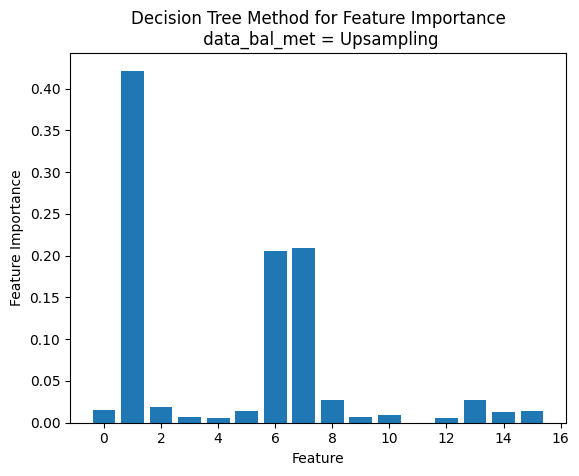

In [194]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

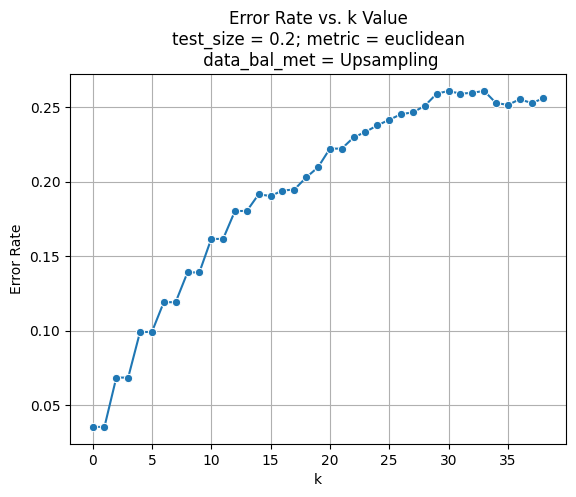

In [195]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[709 110]
 [  0 784]]
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93       819
         1.0       0.88      1.00      0.93       784

    accuracy                           0.93      1603
   macro avg       0.94      0.93      0.93      1603
weighted avg       0.94      0.93      0.93      1603



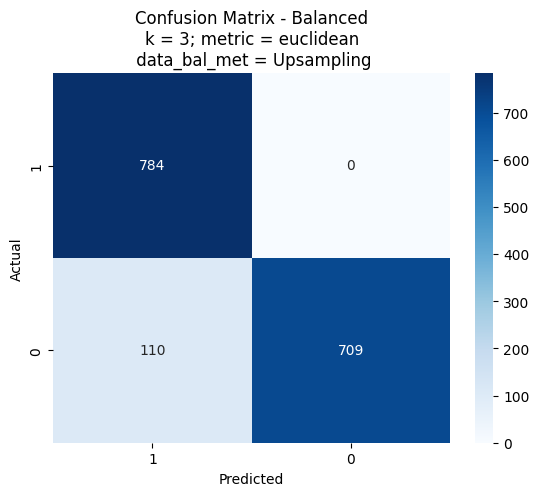

In [197]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.01784
Feature: age, Score: 0.10905
Feature: hypertension, Score: 0.01647
Feature: heart_disease, Score: 0.01734
Feature: ever_married, Score: 0.00150
Feature: Residence_type, Score: 0.01248
Feature: avg_glucose_level, Score: 0.02371
Feature: bmi, Score: 0.02171
Feature: work_type_Private, Score: -0.00262
Feature: work_type_Selfemployed, Score: -0.00374
Feature: work_type_Govtjob, Score: 0.00499
Feature: work_type_Never, Score: -0.00012
Feature: smoking_status_Former, Score: 0.00437
Feature: smoking_status_Never, Score: -0.00162
Feature: smoking_status_Smokes, Score: 0.00250
Feature: smoking_status_Unknown, Score: 0.00549


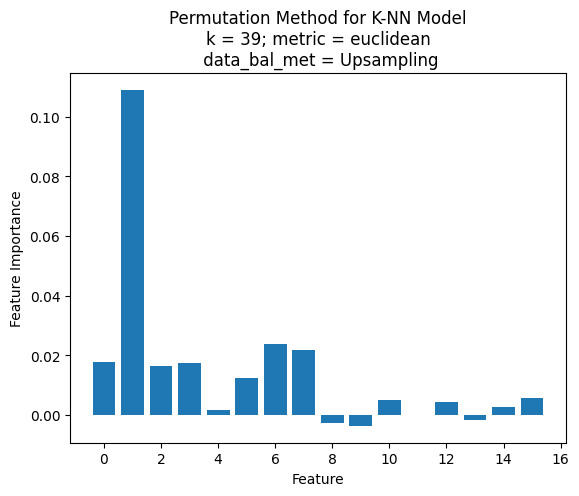

In [196]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[[1779 2227]
 [  82  165]]
              precision    recall  f1-score   support

           0       0.96      0.44      0.61      4006
           1       0.07      0.67      0.13       247

    accuracy                           0.46      4253
   macro avg       0.51      0.56      0.37      4253
weighted avg       0.90      0.46      0.58      4253



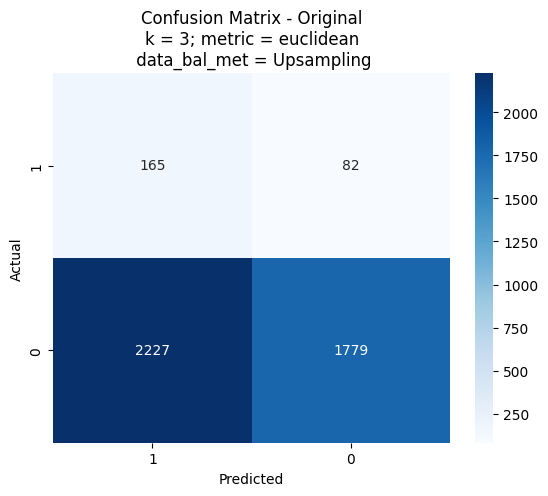

In [198]:
# Evaluate on original data
X_orig = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y_orig = data['stroke']

X_orig_test = scaler.transform(X_orig)
y_orig_pred = knn.predict(X_orig_test)

# Evaluate the model
print(confusion_matrix(y_orig, y_orig_pred))
print(classification_report(y_orig, y_orig_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_orig, y_orig_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Implement Logistic Regression**

In [234]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_up[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_up['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'Upsampling'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



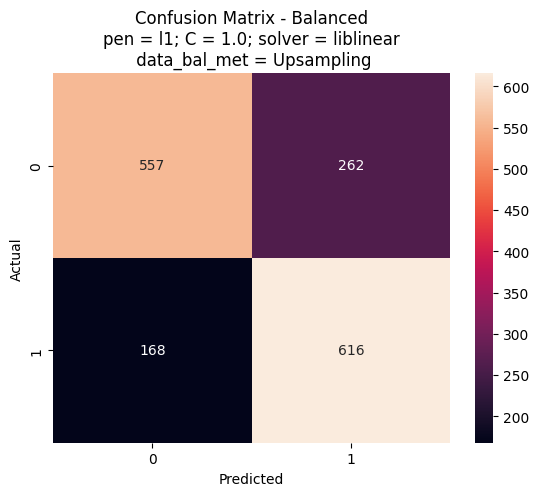

In [236]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [ ]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.68      0.72       819
         1.0       0.70      0.79      0.74       784

    accuracy                           0.73      1603
   macro avg       0.73      0.73      0.73      1603
weighted avg       0.74      0.73      0.73      1603


Confusion Matrix:
[[557 262]
 [168 616]] 



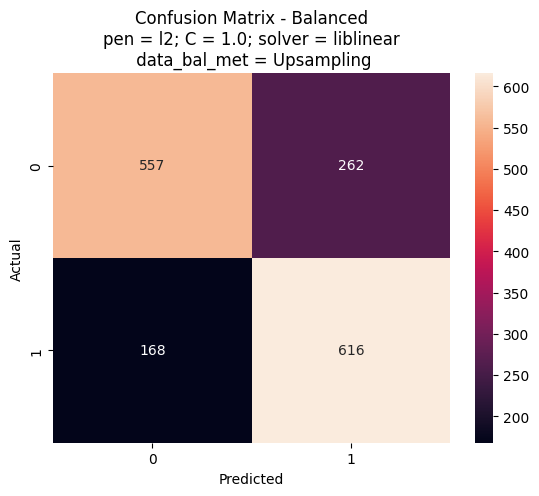

In [238]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [240]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_up.drop('stroke', axis=1)
y = data_up['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.512429
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 8012
Model:                          Logit   Df Residuals:                     7996
Method:                           MLE   Df Model:                           15
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.2607
Time:                        04:34:41   Log-Likelihood:                -4105.6
converged:                      False   LL-Null:                       -5553.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6.1920        nan        nan        nan         nan         nan
gender                     0.

**Data Balancing by SMOTE (Synthetic Minority Oversampling Technique)**

In [199]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
eval_data = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown','stroke']].sample(int(data.shape[0]*0.2),
                                                       random_state = 42)
train_data = data.drop(index = eval_data.index)

X_eval, y_eval = eval_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], eval_data['stroke']
X, y = train_data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']], train_data['stroke']

X, y = oversample.fit_resample(X,y)
data_ups = X.assign(stroke = y)

In [200]:
data_ups['stroke'].value_counts()

1    3218
0    3218
Name: stroke, dtype: int64

**Implement K-NN**

In [201]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature: gender, Score: 0.02997
Feature: age, Score: 0.37056
Feature: hypertension, Score: 0.00880
Feature: heart_disease, Score: 0.01107
Feature: ever_married, Score: 0.01924
Feature: Residence_type, Score: 0.01946
Feature: avg_glucose_level, Score: 0.10057
Feature: bmi, Score: 0.06566
Feature: work_type_Private, Score: 0.03158
Feature: work_type_Selfemployed, Score: 0.01849
Feature: work_type_Govtjob, Score: 0.03005
Feature: work_type_Never, Score: 0.00000
Feature: smoking_status_Former, Score: 0.05669
Feature: smoking_status_Never, Score: 0.07938
Feature: smoking_status_Smokes, Score: 0.08797
Feature: smoking_status_Unknown, Score: 0.07050


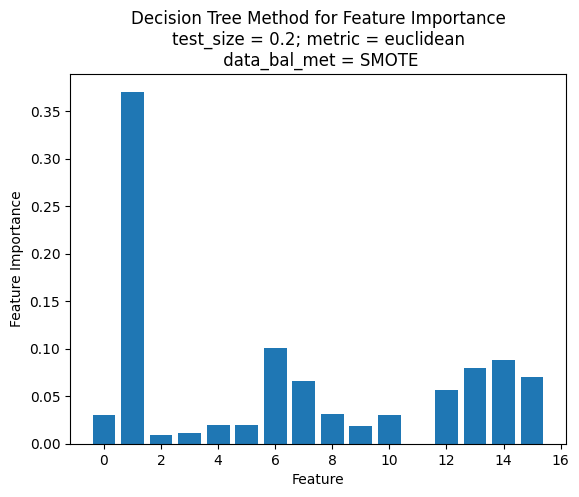

In [202]:
# Decision tree for feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier()
# Fit the model
model.fit(X_train, y_train)
# Get importance
importance = model.feature_importances_
# Summarize feature importance
for count, value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Decision Tree Method for Feature Importance\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

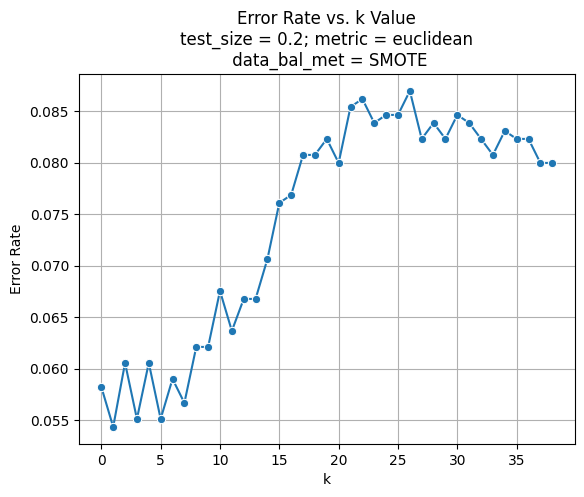

In [203]:
## CONSTANTS
# Test size used
size = 0.2
# Distance metric used
met = 'euclidean'
##

# Check error rate for k = 1 to 40
error_rate = []

for k in range(1, 40):
  knn = KNeighborsClassifier(n_neighbors = k, metric = met)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(1 - accuracy_score(y_test, y_pred))

# Plot line graph of error rate
sns.lineplot(error_rate, marker = 'o')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. k Value\ntest_size = ' + str(size) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met)
plt.show()

[[601  40]
 [ 38 609]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       641
           1       0.94      0.94      0.94       647

    accuracy                           0.94      1288
   macro avg       0.94      0.94      0.94      1288
weighted avg       0.94      0.94      0.94      1288



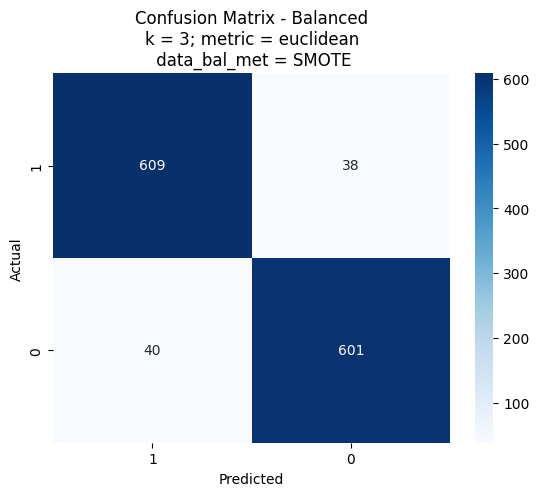

In [207]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K value used
k = 3

# Initialize K-NN classifier and fit the model
knn = KNeighborsClassifier(n_neighbors = k, metric = met)
knn.fit(X_train, y_train)

# Predict using test data
y_pred = knn.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Balanced\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

Feature: gender, Score: 0.02050
Feature: age, Score: 0.04736
Feature: hypertension, Score: 0.00668
Feature: heart_disease, Score: 0.01087
Feature: ever_married, Score: 0.01009
Feature: Residence_type, Score: 0.01755
Feature: avg_glucose_level, Score: 0.02671
Feature: bmi, Score: 0.02003
Feature: work_type_Private, Score: 0.08385
Feature: work_type_Selfemployed, Score: 0.04798
Feature: work_type_Govtjob, Score: 0.03773
Feature: work_type_Never, Score: 0.00031
Feature: smoking_status_Former, Score: 0.07267
Feature: smoking_status_Never, Score: 0.12904
Feature: smoking_status_Smokes, Score: 0.07702
Feature: smoking_status_Unknown, Score: 0.09053


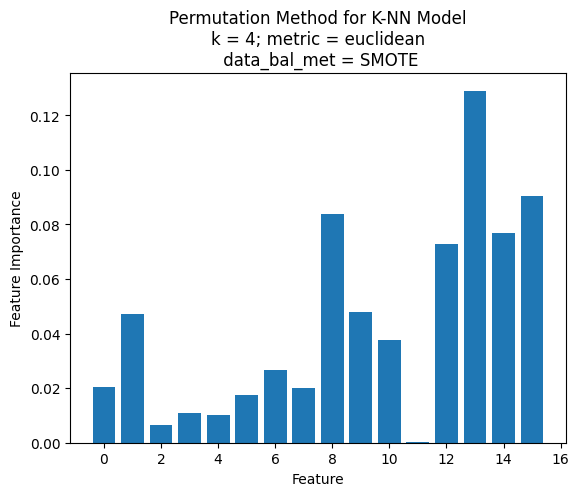

In [205]:
# Permutation for feature importance with K-NN for classification
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Fit the model
results = permutation_importance(knn, X_test, y_test, scoring = 'accuracy')
# Get importance
importance = results.importances_mean
# Summarize feature importance
for count,value in enumerate(importance):
  print('Feature: ' + X.columns[count] + ', Score: %.5f' % value)
# Plot feature importance
plt.bar([x for x in range(len(importance))], importance)
title = 'Permutation Method for K-NN Model\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[[1443 2563]
 [  59  188]]
              precision    recall  f1-score   support

           0       0.96      0.36      0.52      4006
           1       0.07      0.76      0.13       247

    accuracy                           0.38      4253
   macro avg       0.51      0.56      0.32      4253
weighted avg       0.91      0.38      0.50      4253



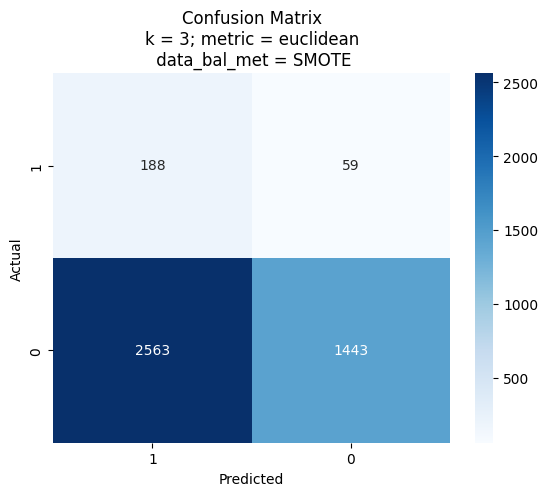

In [208]:
# Evaluate on original data
X_orig = data[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y_orig = data['stroke']

X_orig_test = scaler.transform(X_orig)
y_orig_pred = knn.predict(X_orig_test)

# Evaluate the model
print(confusion_matrix(y_orig, y_orig_pred))
print(classification_report(y_orig, y_orig_pred))

# Visualize K-NN results using confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique classes
classes = data['stroke'].unique()

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_orig, y_orig_pred, labels = classes), annot = True,
            xticklabels = classes, yticklabels = classes, cmap = 'Blues',
            fmt = 'g')

plt.xlabel('Predicted')
plt.ylabel('Actual')
title = 'Confusion Matrix - Original\nk = ' + str(k) + '; metric = ' + met + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

**Implement Logistic Regression**

In [218]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Split data into features and label for feature importance
##  Features: gender	age	hypertension	heart_disease	ever_married	Residence_type
##            avg_glucose_level	bmi	work_type_Private	work_type_Selfemployed
##            work_type_Govtjob	work_type_Never smoking_status_Former
##            smoking_status_Never  smoking_status_Smokes smoking_status_Unknown
##  Label:    stroke

## CONSTANTS
X = data_ups[['gender','age','hypertension','heart_disease','ever_married',
            'Residence_type','avg_glucose_level','bmi','work_type_Private',
            'work_type_Selfemployed','work_type_Govtjob','work_type_Never',
            'smoking_status_Former','smoking_status_Never','smoking_status_Smokes',
            'smoking_status_Unknown']]
y = data_ups['stroke']
# Test size used
size = 0.2
# Data balancing method used
data_bal_met = 'SMOTE'
##

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size,
                                                    random_state = 42)

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
## CONSTANTS
pen = 'l1'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       641
           1       0.97      0.88      0.92       647

    accuracy                           0.92      1288
   macro avg       0.93      0.92      0.92      1288
weighted avg       0.93      0.92      0.92      1288


Confusion Matrix:
[[621  20]
 [ 77 570]] 



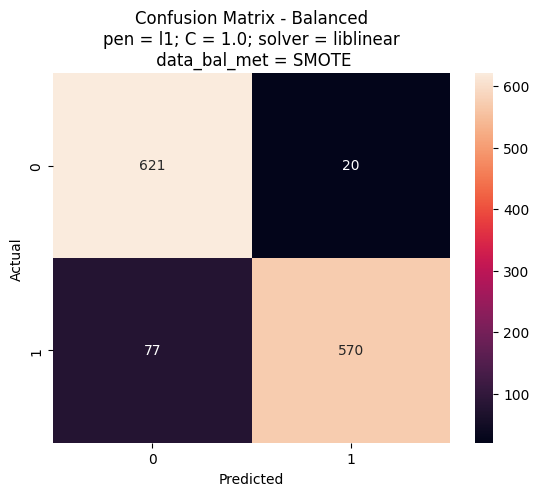

In [229]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [ ]:
## CONSTANTS
pen = 'l2'
reg = 1.0
solv = 'liblinear'
##

# Training logistic regression model, with L2 instead
log_reg = LogisticRegression(penalty=pen, C=reg, solver=solv)
  #L1 to help with feature selection
  #C=1 is moderate regularization
  #liblinear is good for binary outcomes
log_reg.fit(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       641
           1       0.96      0.88      0.92       647

    accuracy                           0.92      1288
   macro avg       0.93      0.92      0.92      1288
weighted avg       0.93      0.92      0.92      1288


Confusion Matrix:
[[619  22]
 [ 77 570]] 



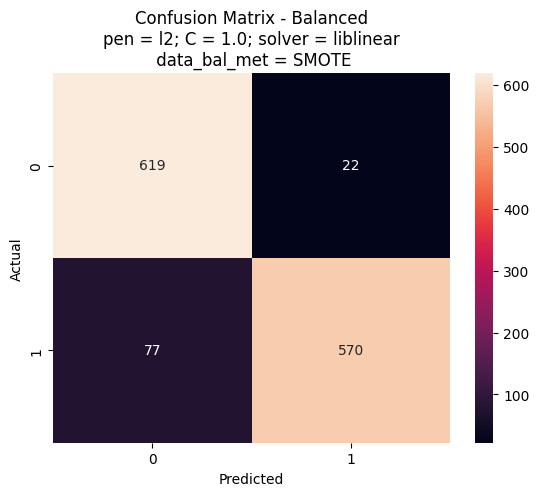

In [232]:
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix,"\n")

# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
title = 'Confusion Matrix - Balanced\npen = ' + pen + '; C = ' + str(reg) + '; solver = ' + solv + '\n data_bal_met = ' + data_bal_met
plt.title(title)

plt.show()

In [233]:
### model summary

import statsmodels.api as sm
import pandas as pd

# Separate features and target variable
X = data_ups.drop('stroke', axis=1)
y = data_ups['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.174610
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 6436
Model:                          Logit   Df Residuals:                     6419
Method:                           MLE   Df Model:                           16
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:                  0.7481
Time:                        04:31:23   Log-Likelihood:                -1123.8
converged:                      False   LL-Null:                       -4461.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     25.9767    402.673      0.065      0.949    -763.249     815.202
gender                    -1.